Welcome to the Lab session of the ReLearn Course. This notebook contains three sections with problems spacing the content of the course.

Just a few indications:
- There are questions where you will be required to explain your design choices or some results. Be as informative as possible, but try to keep it concise!
- Comments on the results are well accepted and encouraged.
- In the last section, some code is already provided. Feel free to modify it if you need to, but remember to comment on it to make the modifications understandable.


**Submission:** Once completed, submit the notebook file (.ipynb) and the PDF file (.pdf) with all the cell ran and with their output visible.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Options: Keep or Sell?

An investor has the option to sell a given amount of stock at any one of $N$ time periods. The initial price of the stock is an integer $x_0$. The price $x_k$, if it is positive and it is less than a given positive integer value $\bar{x}$, it evolves according to:

$$
x_{k+1} =
\begin{cases}
\min\{\bar{x}, x_k + 1\} &~\text{with probability}~p^+\\
x_k + 1 &~\text{with probability}~1 - p^+ -p^-\\
\max\{0,x_k - 1\} &~\text{with probability}~p^-
\end{cases}
$$

with probabilities $p^+$ and $p^-$ known. \\
At each period $k = 0,...,N − 1$ for which the stock has not yet been sold,
the investor (with knowledge of the current price $x_k$), can either sell the stock at the current price $x_k$ or postpone the sale for a future period. If the stock has not been sold at any of the periods $k = 0,...,N − 1$, it must be sold at period $N$ at price $x_N$. The investor wants to maximize the expected value of the sale.

## Question 1: DP formulation

Formulate the problem as a finite horizon DP problem by identifying the
state, control, and disturbance spaces, the system equation and the cost function. Brefly explain your reasoning.

**Answer Here:**

Using the derived formulation, compute the optimal cost function and policy with the following system parameters $\{N = 15, x_0 = 4, \bar{x} = 10,  p^+ = p^- = 0.25\}$.

## Question 2: Heuristic Policy

Suppose the investor adopts a heuristic, referred to as base heuristic, whereby
they sells the stock if its price is greater or equal to $\beta \cdot x_0$, with $\beta > 1$. Write an exact DP algorithm to compute the expected
value of the sale under this heuristic.

## Question 3: Rollout

Apply approximation in value space with one-step lookahead minimization
and with function approximation that is based on the heuristic of Question 2. \\

In particular, use  $\tilde{J}(x_N) = x_N$ , and for $k = 1,...,N − 1$, use $\tilde{J}_k(x_k)$ that is equal to the expected value of the sale when starting at x_k and using the heuristic that sells the stock when its price exceeds $\beta \cdot x_k$.

# Linear Quadratic Problem

In the following section, we focus on the one-dimensional undiscounted linear quadratic problem. Furthermore, we will discuss the interpretation of approximation space as a Newton step for the solution of the Riccati equation.

**Throughout this section, we will set the system parameters as $\{a = 2, b = 1, q = 1, r = 5\}$**. However, it is encouraged to experiment with different system values.

In [ ]:
a = 2; b = 1; q = 1; r = 5;

## Question 1: Graphical solution of Riccati Equation

Define the Riccati operator $F(K)$ and plot it on and appropriate domain, e.g, $[5,25]$. How do you identify the unique stable solution of the Riccati equation? Brefly explain it and show it graphically on the plot.

## Question 2: Control Constrained Riccati Equation

Plot and solve graphically the Riccati equation corresponding to the linear policy $\mu(x) = -\frac{3}{2}x$.

## Question 3: Value Iteration (VI)

Compute the numerical solution of Riccati equation using value iteration and plot the iterations $K_0,K_1,K_2, \ldots$ on the curve $F(K)$. Check the convergence for different starting points, i.e. $K_0 < K^*$ and $K^* > K_0$.

## Question 4: Value Approximation as Newton Step

Assume a terminal cost approximation $\tilde{K}$. Using the functions $F_L$, show graphically how the approximation in value space with $l$-step lookahead, with $l = \{1,2,3\}$, can be seen as successive application of Newton method.

**Bonus:** How does the stability set, i.e., the set of $\tilde{K}$ for which the resulting policy is stable, change with multiple lookahead steps?

# Robotic Exploration

Consider a world constituted by a rectangular grid, e.g.,

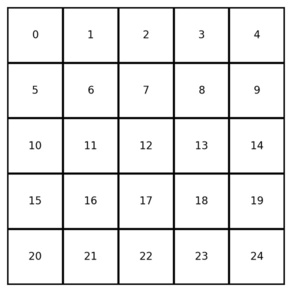

The cells of the grid correspond to the states of the environment. At each cell, four actions are possible: north (N), south (S), east (E), and west (W), which deterministically cause the agent to move one cell in the respective direction on the grid.
The objective is to find the closest source of water. At each step, depending on the type of terrain, the robot will consume a fixed amount of energy, i.e. 1 for flat terrain, 2 for forest terrain, 10 for fire terrain, etc.

 We start by explaining the implementation of the world class, representing our environment, by commenting the code.

In [ ]:
class World(object):
    def __init__(self, gridSize, terrain):

        #The world is represented as m x n matrix
        self.m = gridSize[0]
        self.n = gridSize[1]
        self.grid = np.zeros(gridSize)

        #The state space is represented by the position of the robot in our grid.
        #We can list all possible states by enumerating, as in the previous figure,
        #the locations in row-major order.
        self.state_space = list(range(self.m * self.n))

        #We fix a base cost to move between locations, which,
        #depending on the terrain type, will be modified.
        self.step_reward = -1

        #We store the dictionary
        #{"terrain-type": { "loc": [],          ## list of indexes of position of that terrain type
        #                   "reward": a }}      ## reward associated with that terrain
        self.terrain = terrain

        #Definition of the action space, which corresponds with the four possible directions.
        self.action_space = {'N': -self.m, 'S': self.m, 'W': -1, 'E': 1, 'R': 0}
        self.actions = ['N', 'S', 'W', 'E', 'R']

        #Set up the dictionary indexed by the tuple (state, action) containing the Q-values Q(s,a)
        self.P = self.int_P()

    def int_P(self):
        #For each (state, action) tuple, associate a (next_state, reward) tuple.
        P = {}
        for state in self.state_space:
            for action in self.actions:
                reward = self.step_reward
                n_state = state + self.action_space[action]

                if n_state in self.terrain.get('fire').get('loc'):
                    reward += self.terrain.get('fire').get('reward')

                elif n_state in self.terrain.get('rock').get('loc'):
                    reward += self.terrain.get('rock').get('reward')

                elif n_state in self.terrain.get('water').get('loc'):
                    reward += self.terrain.get('water').get('reward')

                elif self.check_move(n_state, state):
                    n_state = state

                P[(state ,action)] = (n_state, reward)
        return P

    def check_terminal(self, state):
        #Check if the location is a water location, i.e. it is a terminal state.
        return state in self.terrain.get('water').get('loc')

    def check_move(self, n_state, oldState):
        #Check if the movement is valid, i.e., still inside the world border.
        if n_state not in self.state_space:
            return True
        elif oldState % self.m == 0 and n_state % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and n_state % self.m == 0:
            return True
        else:
            return False

## Question 1: Value Iteration
Your task is to implement the Value-Iteration algorithm to compute the optimal exploration policy. \\
As a reminder, the pseudo code of VI is given in the following:

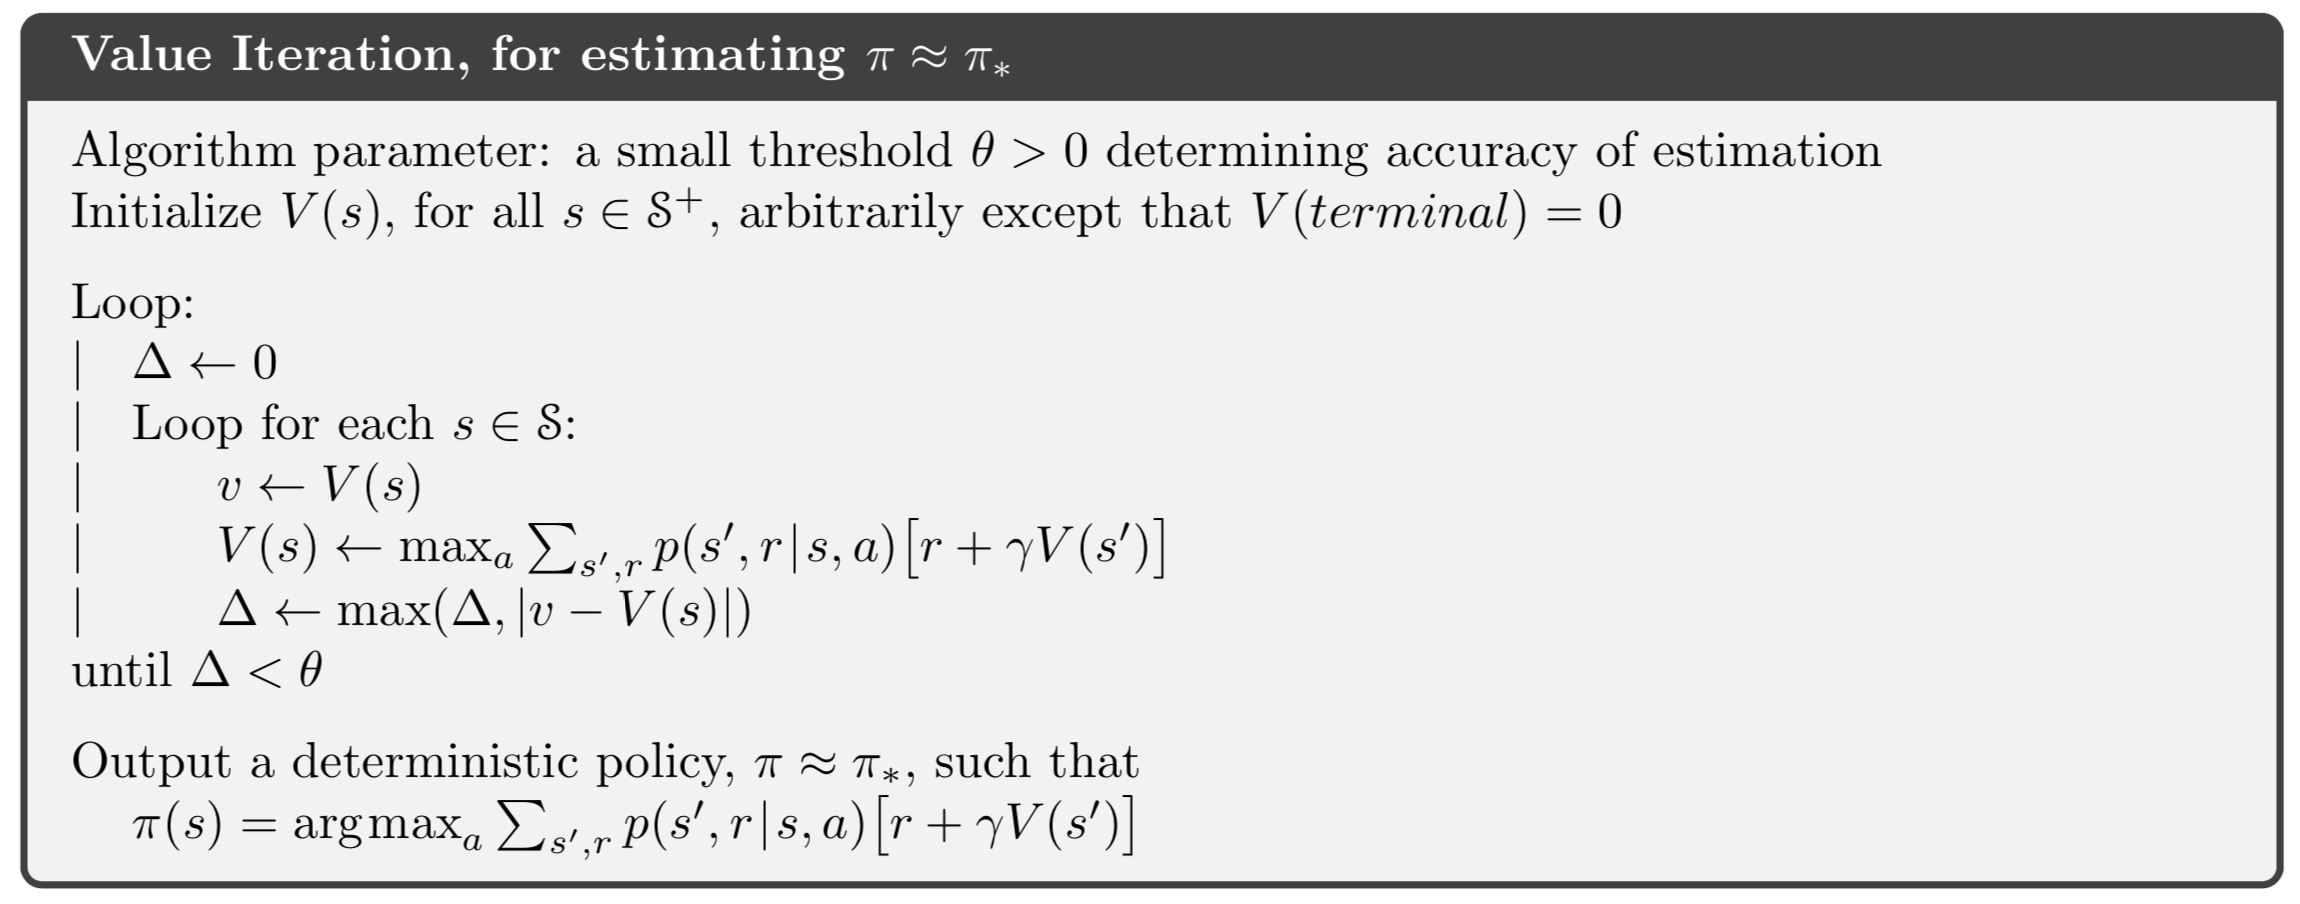

In [ ]:
def ValueIteration(grid, v , policy):
    #grid <- instance of World()
    #v <- array storing the cost J for each state
    #policy <- array indexed by states storing the policy action

    ## VALUE ITERATION LOOP


    ## OPTIMAL DETERIMINISTIC POLICY COMPUTATION

    return v, policy

Now, test the implemented algorithm on the following example.

In [ ]:
# Instantiate the World
## It is possible to implement other terrains by modifing the World() class

grid_size = (5, 5)
items = { 'fire': {'reward': -10, 'loc': [12, 14, 19, 22, 23, 24]},
          'rock': {'reward': -1, 'loc': [13, 17]},
          'water': {'reward': 10, 'loc': [18, 0]}
        }

env = World(grid_size, items)


# Training using VI
v = np.zeros(np.prod(grid_size))              #All rewards are initially set to 0
policy = np.full(np.prod(grid_size), 'R')     #Initiallize with a "random" action

v, policy = ValueIteration(env, v, policy)

100 iterations of state space


The following function allow to plot the results of the VI and the optimal policy.

In [ ]:
def print_v(v, grid):
    v = np.reshape(v, (grid.n, grid.m))

    cmap = mpl.colormaps['Greens']
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.terrain.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.terrain.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    for f in grid.terrain.get('rock').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.5, 1

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
              text = ax.text(j, i, v[i, j], ha="center", va="center", color="w")

    plt.axis('off')
    plt.show()


def print_policy(v, policy, grid):
    v = np.reshape(v, (grid.n, grid.m))
    policy = np.reshape(policy, (grid.n, grid.m))

    cmap = mpl.colormaps['Greens']
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.terrain.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.terrain.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    for f in grid.terrain.get('rock').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.5, 1

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            text = ax.text(j, i, policy[i, j], ha="center", va="center", color="w")

    plt.axis('off')
    plt.show()

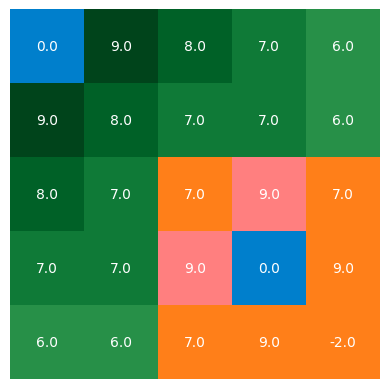

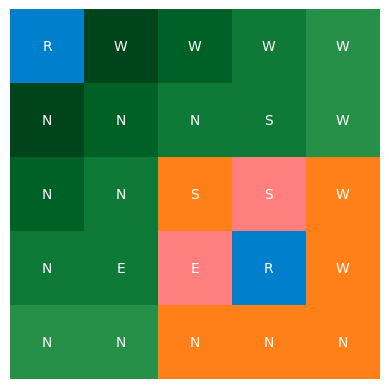

In [ ]:
print_v(v, env)
print_policy(v, policy, env)

## Question 2: Curse of Dimensionality

Consider the following example where a map of size NxN is randomly generated. How does the complexity of the VI algorithm depends on N? Plot the training time as function of N and explain the results.

In [ ]:
# Instantiate the World
## It is possible to implement other terrains by modifing the World() class
import random

N = 10
grid_size = (N, N)
n_squares = grid_size[0] * grid_size[1]
NW = int(np.ceil(0.02 * n_squares))
NF = int(np.ceil(0.25 * n_squares))
NR = int(np.ceil(0.25 * n_squares))
locs = random.sample(range(1, n_squares), NW + NF + NR)
items = { 'water': {'reward': 10, 'loc': locs[0:NW]},
          'fire': {'reward': -10, 'loc': locs[NW: NW + NF]},
          'rock': {'reward': -1, 'loc': locs[NW+NF:]}
        }

env = World(grid_size, items)


# Training using VI
v = np.zeros(np.prod(grid_size))              #All rewards are initially set to 0
policy = np.full(np.prod(grid_size), 'R')     #Initiallize with a "random" action

v, policy = ValueIteration(env, v, policy)

1200 iterations of state space


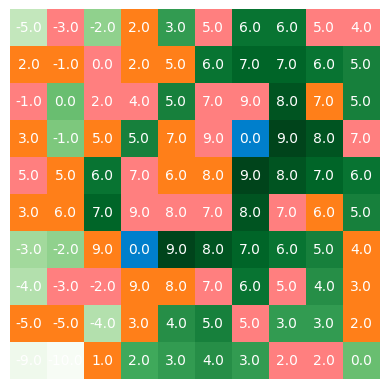

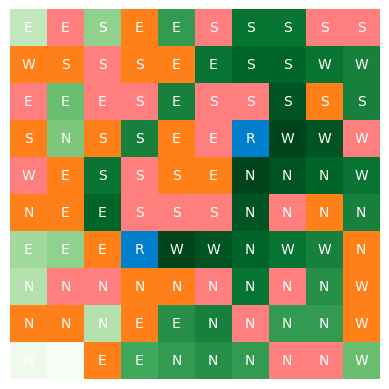

In [ ]:
print_v(v, env)
print_policy(v, policy, env)